In [1]:

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
base_dir = r'./data/cons/training'
train_test_split = 0.7
no_of_files_in_each_class = 10

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just 5 images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)       

13 categories found in the dataset
X, Y shape (130, 100, 100, 3) (130,) (13, 10)


In [3]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)

9 classes for training and 4  classes for testing
X&Y shape of training data : (90, 100, 100, 3) and (90,) (9, 10)
X&Y shape of testing data : (40, 100, 100, 3) and (40,) (4, 10)


In [4]:

def get_batch(batch_size=64):
    
    temp_x = x_train
    temp_cat_list = cat_train
    start=0
    end=train_size
    batch_x=[]
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

C:\Users\choij\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


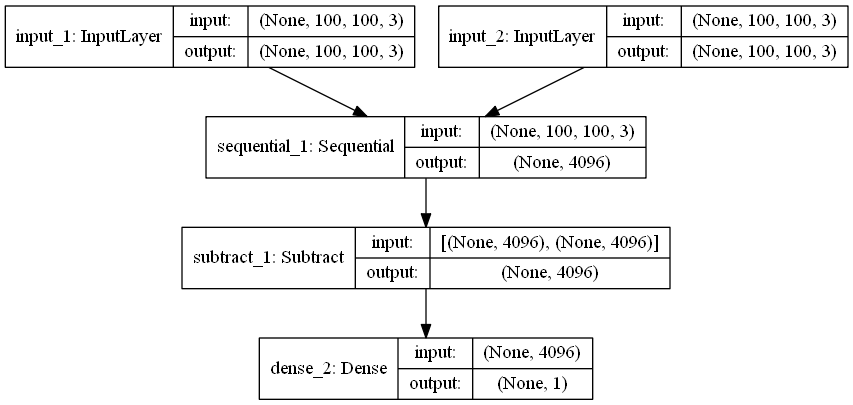

In [5]:
#Building a sequential model
input_shape=(100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (7,7), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(256, (4,4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='sigmoid', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)

subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(input=[left_input, right_input], output=prediction)

optimizer= Adam(learning_rate=0.0006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

plot_model(siamese_net, show_shapes=True, show_layer_names=True)

In [6]:
def nway_one_shot(model, n_way, n_val):
    
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy
            

In [ ]:

epochs = 5000
n_way = 10
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in range(1,epochs):
    batch_x, batch_y = get_batch(batch_size)#, call_type="train")
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%250 == 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")
            #break

Epoch: 1 , Loss: 0.7503922
Epoch: 2 , Loss: 0.751342
Epoch: 3 , Loss: 0.74956083
Epoch: 4 , Loss: 0.7481377
Epoch: 5 , Loss: 0.74964416
Epoch: 6 , Loss: 0.7475433
Epoch: 7 , Loss: 0.74806947
Epoch: 8 , Loss: 0.7459091
Epoch: 9 , Loss: 0.7486526
Epoch: 10 , Loss: 0.74333274
Epoch: 11 , Loss: 0.74305135
Epoch: 12 , Loss: 0.7507272
Epoch: 13 , Loss: 0.7437617
Epoch: 14 , Loss: 0.736771
Epoch: 15 , Loss: 0.74381405
Epoch: 16 , Loss: 0.7339327
Epoch: 17 , Loss: 0.7260487
Epoch: 18 , Loss: 0.7511966
Epoch: 19 , Loss: 0.79756784
Epoch: 20 , Loss: 0.7360926
Epoch: 21 , Loss: 0.7423049
Epoch: 22 , Loss: 0.74109524
Epoch: 23 , Loss: 0.74129707
Epoch: 24 , Loss: 0.73984635
Epoch: 25 , Loss: 0.7395073
Epoch: 26 , Loss: 0.73909914
Epoch: 27 , Loss: 0.73892444
Epoch: 28 , Loss: 0.73858136
Epoch: 29 , Loss: 0.73857325
Epoch: 30 , Loss: 0.7380568
Epoch: 31 , Loss: 0.7377904
Epoch: 32 , Loss: 0.7375144
Epoch: 33 , Loss: 0.7372474
Epoch: 34 , Loss: 0.73698485
Epoch: 35 , Loss: 0.7367265
Epoch: 36 , Loss

Epoch: 279 , Loss: 0.7107962
Epoch: 280 , Loss: 0.7107722
Epoch: 281 , Loss: 0.7105987
Epoch: 282 , Loss: 0.7103814
Epoch: 283 , Loss: 0.7101749
Epoch: 284 , Loss: 0.710651
Epoch: 285 , Loss: 0.71038365
Epoch: 286 , Loss: 0.7109938
Epoch: 287 , Loss: 0.7100586
Epoch: 288 , Loss: 0.7100183
Epoch: 289 , Loss: 0.7100787
Epoch: 290 , Loss: 0.70986634
Epoch: 291 , Loss: 0.71019286
Epoch: 292 , Loss: 0.7123488
Epoch: 293 , Loss: 0.7089418
Epoch: 294 , Loss: 0.70970154
Epoch: 295 , Loss: 0.7099095
Epoch: 296 , Loss: 0.7104082
Epoch: 297 , Loss: 0.70975757
Epoch: 298 , Loss: 0.70982355
Epoch: 299 , Loss: 0.7218523
Epoch: 300 , Loss: 0.7096203
Epoch: 301 , Loss: 0.709772
Epoch: 302 , Loss: 0.70979637
Epoch: 303 , Loss: 0.7100818
Epoch: 304 , Loss: 0.7103383
Epoch: 305 , Loss: 0.710534
Epoch: 306 , Loss: 0.71075404
Epoch: 307 , Loss: 0.7109647
Epoch: 308 , Loss: 0.711161
Epoch: 309 , Loss: 0.71133995
Epoch: 310 , Loss: 0.7114986
Epoch: 311 , Loss: 0.7116379
Epoch: 312 , Loss: 0.7117546
Epoch: 31

Epoch: 553 , Loss: 0.7008344
Epoch: 554 , Loss: 0.7008032
Epoch: 555 , Loss: 0.70077014
Epoch: 556 , Loss: 0.7007455
Epoch: 557 , Loss: 0.7007374
Epoch: 558 , Loss: 0.7007144
Epoch: 559 , Loss: 0.70068663
Epoch: 560 , Loss: 0.7006272
Epoch: 561 , Loss: 0.70059675
Epoch: 562 , Loss: 0.7005657
Epoch: 563 , Loss: 0.7005438
Epoch: 564 , Loss: 0.70051515
Epoch: 565 , Loss: 0.7004843
Epoch: 566 , Loss: 0.70045435
Epoch: 567 , Loss: 0.7004286
Epoch: 568 , Loss: 0.7003991
Epoch: 569 , Loss: 0.70037353
Epoch: 570 , Loss: 0.70034844
Epoch: 571 , Loss: 0.70032394
Epoch: 572 , Loss: 0.7002968
Epoch: 573 , Loss: 0.70026577
Epoch: 574 , Loss: 0.7002338
Epoch: 575 , Loss: 0.70021105
Epoch: 576 , Loss: 0.7001858
Epoch: 577 , Loss: 0.70015705
Epoch: 578 , Loss: 0.7001276
Epoch: 579 , Loss: 0.70010924
Epoch: 580 , Loss: 0.7000724
Epoch: 581 , Loss: 0.70004684
Epoch: 582 , Loss: 0.7000296
Epoch: 583 , Loss: 0.6999931
Epoch: 584 , Loss: 0.6999777
Epoch: 585 , Loss: 0.6999476
Epoch: 586 , Loss: 0.69991976


Epoch: 827 , Loss: 0.6960758
Epoch: 828 , Loss: 0.69585174
Epoch: 829 , Loss: 0.69609314
Epoch: 830 , Loss: 0.69580203
Epoch: 831 , Loss: 0.69579357
Epoch: 832 , Loss: 0.69580764
Epoch: 833 , Loss: 0.6958018
Epoch: 834 , Loss: 0.695796
Epoch: 835 , Loss: 0.69579136
Epoch: 836 , Loss: 0.695784
Epoch: 837 , Loss: 0.695775
Epoch: 838 , Loss: 0.6957644
Epoch: 839 , Loss: 0.6957593
Epoch: 840 , Loss: 0.6957483
Epoch: 841 , Loss: 0.6957348
Epoch: 842 , Loss: 0.69572926
Epoch: 843 , Loss: 0.6957128
Epoch: 844 , Loss: 0.69570357
Epoch: 845 , Loss: 0.6956909
Epoch: 846 , Loss: 0.695676
Epoch: 847 , Loss: 0.69566625
Epoch: 848 , Loss: 0.6956524
Epoch: 849 , Loss: 0.69563985
Epoch: 850 , Loss: 0.69563127
Epoch: 851 , Loss: 0.6956185
Epoch: 852 , Loss: 0.69560766
Epoch: 853 , Loss: 0.6955934
Epoch: 854 , Loss: 0.69558394
Epoch: 855 , Loss: 0.69557154
Epoch: 856 , Loss: 0.6955536
Epoch: 857 , Loss: 0.69554555
Epoch: 858 , Loss: 0.6955381
Epoch: 859 , Loss: 0.695527
Epoch: 860 , Loss: 0.6955111
Epoc

Epoch: 1098 , Loss: 0.69414276
Epoch: 1099 , Loss: 0.6930129
Epoch: 1100 , Loss: 0.6924726
Epoch: 1101 , Loss: 0.699532
Epoch: 1102 , Loss: 0.6938537
Epoch: 1103 , Loss: 0.69526654
Epoch: 1104 , Loss: 0.67811996
Epoch: 1105 , Loss: 0.71154267
Epoch: 1106 , Loss: 0.7012596
Epoch: 1107 , Loss: 0.6990886
Epoch: 1108 , Loss: 0.697808
Epoch: 1109 , Loss: 0.6981376
Epoch: 1110 , Loss: 0.69861037
Epoch: 1111 , Loss: 0.6992889
Epoch: 1112 , Loss: 0.69977736
Epoch: 1113 , Loss: 0.7002055
Epoch: 1114 , Loss: 0.7006193
Epoch: 1115 , Loss: 0.700918
Epoch: 1116 , Loss: 0.7011314
Epoch: 1117 , Loss: 0.70133334
Epoch: 1118 , Loss: 0.70146686
Epoch: 1119 , Loss: 0.7017259
Epoch: 1120 , Loss: 0.7016075
Epoch: 1121 , Loss: 0.70173293
Epoch: 1122 , Loss: 0.7056044
Epoch: 1123 , Loss: 0.70357406
Epoch: 1124 , Loss: 0.70067745
Epoch: 1125 , Loss: 0.70101887
Epoch: 1126 , Loss: 0.70126706
Epoch: 1127 , Loss: 0.70188594
Epoch: 1128 , Loss: 0.7026002
Epoch: 1129 , Loss: 0.7005026
Epoch: 1130 , Loss: 0.7014413

Epoch: 1363 , Loss: 0.69549817
Epoch: 1364 , Loss: 0.69545823
Epoch: 1365 , Loss: 0.6954195
Epoch: 1366 , Loss: 0.695382
Epoch: 1367 , Loss: 0.6953456
Epoch: 1368 , Loss: 0.69531035
Epoch: 1369 , Loss: 0.6952762
Epoch: 1370 , Loss: 0.69524306
Epoch: 1371 , Loss: 0.695211
Epoch: 1372 , Loss: 0.6951799
Epoch: 1373 , Loss: 0.6951496
Epoch: 1374 , Loss: 0.6951204
Epoch: 1375 , Loss: 0.6950921
Epoch: 1376 , Loss: 0.6950644
Epoch: 1377 , Loss: 0.69503766
Epoch: 1378 , Loss: 0.6950121
Epoch: 1379 , Loss: 0.6949866
Epoch: 1380 , Loss: 0.69496197
Epoch: 1381 , Loss: 0.6949381
Epoch: 1382 , Loss: 0.69491595
Epoch: 1383 , Loss: 0.69489247
Epoch: 1384 , Loss: 0.69487154
Epoch: 1385 , Loss: 0.69485813
Epoch: 1386 , Loss: 0.694819
Epoch: 1387 , Loss: 0.69478136
Epoch: 1388 , Loss: 0.6948163
Epoch: 1389 , Loss: 0.69478375
Epoch: 1390 , Loss: 0.6947519
Epoch: 1391 , Loss: 0.6947342
Epoch: 1392 , Loss: 0.6947165
Epoch: 1393 , Loss: 0.6946995
Epoch: 1394 , Loss: 0.6946845
Epoch: 1395 , Loss: 0.6946677
E

Epoch: 1628 , Loss: 0.6935853
Epoch: 1629 , Loss: 0.6935856
Epoch: 1630 , Loss: 0.6935821
Epoch: 1631 , Loss: 0.6935824
Epoch: 1632 , Loss: 0.6935764
Epoch: 1633 , Loss: 0.6935787
Epoch: 1634 , Loss: 0.6935737
Epoch: 1635 , Loss: 0.693574
Epoch: 1636 , Loss: 0.6935708
Epoch: 1637 , Loss: 0.69356763
Epoch: 1638 , Loss: 0.69356763
Epoch: 1639 , Loss: 0.6935623
Epoch: 1640 , Loss: 0.6935653
Epoch: 1641 , Loss: 0.6935683
Epoch: 1642 , Loss: 0.69354916
Epoch: 1643 , Loss: 0.6935574
Epoch: 1644 , Loss: 0.69358724
Epoch: 1645 , Loss: 0.69360846
Epoch: 1646 , Loss: 0.6935458
Epoch: 1647 , Loss: 0.69355375
Epoch: 1648 , Loss: 0.6935527
Epoch: 1649 , Loss: 0.69354916
Epoch: 1650 , Loss: 0.6935466
Epoch: 1651 , Loss: 0.6935441
Epoch: 1652 , Loss: 0.69354385
Epoch: 1653 , Loss: 0.69354326
Epoch: 1654 , Loss: 0.69354045
Epoch: 1655 , Loss: 0.69353884
Epoch: 1656 , Loss: 0.6935407
Epoch: 1657 , Loss: 0.6935364
Epoch: 1658 , Loss: 0.6935333
Epoch: 1659 , Loss: 0.6935254
Epoch: 1660 , Loss: 0.6935322


Epoch: 1893 , Loss: 0.69393176
Epoch: 1894 , Loss: 0.6939392
Epoch: 1895 , Loss: 0.6939092
Epoch: 1896 , Loss: 0.69384104
Epoch: 1897 , Loss: 0.6938891
Epoch: 1898 , Loss: 0.69389886
Epoch: 1899 , Loss: 0.6938995
Epoch: 1900 , Loss: 0.69392383
Epoch: 1901 , Loss: 0.69388175
Epoch: 1902 , Loss: 0.6938843
Epoch: 1903 , Loss: 0.6938489
Epoch: 1904 , Loss: 0.6938498
Epoch: 1905 , Loss: 0.6938372
Epoch: 1906 , Loss: 0.6938214
Epoch: 1907 , Loss: 0.6938252
Epoch: 1908 , Loss: 0.69381636
Epoch: 1909 , Loss: 0.6937924
Epoch: 1910 , Loss: 0.6937933
Epoch: 1911 , Loss: 0.69377583
Epoch: 1912 , Loss: 0.69378096
Epoch: 1913 , Loss: 0.693787
Epoch: 1914 , Loss: 0.69373316
Epoch: 1915 , Loss: 0.6937487
Epoch: 1916 , Loss: 0.6937082
Epoch: 1917 , Loss: 0.6936669
Epoch: 1918 , Loss: 0.6938505
Epoch: 1919 , Loss: 0.69374335
Epoch: 1920 , Loss: 0.6940335
Epoch: 1921 , Loss: 0.69363725
Epoch: 1922 , Loss: 0.6937631
Epoch: 1923 , Loss: 0.69365895
Epoch: 1924 , Loss: 0.6936672
Epoch: 1925 , Loss: 0.6936787

Epoch: 2158 , Loss: 0.7011524
Epoch: 2159 , Loss: 0.70167357
Epoch: 2160 , Loss: 0.7014935
Epoch: 2161 , Loss: 0.7007452
Epoch: 2162 , Loss: 0.70136595
Epoch: 2163 , Loss: 0.7012375
Epoch: 2164 , Loss: 0.7011003
Epoch: 2165 , Loss: 0.7009555
Epoch: 2166 , Loss: 0.70080537
Epoch: 2167 , Loss: 0.70065063
Epoch: 2168 , Loss: 0.7004929
Epoch: 2169 , Loss: 0.7003333
Epoch: 2170 , Loss: 0.70017284
Epoch: 2171 , Loss: 0.7000124
Epoch: 2172 , Loss: 0.6998527
Epoch: 2173 , Loss: 0.69969445
Epoch: 2174 , Loss: 0.69953763
Epoch: 2175 , Loss: 0.69969106
Epoch: 2176 , Loss: 0.69923395
Epoch: 2177 , Loss: 0.69908804
Epoch: 2178 , Loss: 0.6989466
Epoch: 2179 , Loss: 0.69880915
Epoch: 2180 , Loss: 0.69867593
Epoch: 2181 , Loss: 0.6985467
Epoch: 2182 , Loss: 0.6984213
Epoch: 2183 , Loss: 0.69829977
Epoch: 2184 , Loss: 0.6981809
Epoch: 2185 , Loss: 0.698068
Epoch: 2186 , Loss: 0.6979576
Epoch: 2187 , Loss: 0.69785064
Epoch: 2188 , Loss: 0.6977471
Epoch: 2189 , Loss: 0.69764715
Epoch: 2190 , Loss: 0.6975

Epoch: 2423 , Loss: 0.6992907
Epoch: 2424 , Loss: 0.69924676
Epoch: 2425 , Loss: 0.6992027
Epoch: 2426 , Loss: 0.6991586
Epoch: 2427 , Loss: 0.6991146
Epoch: 2428 , Loss: 0.69907093
Epoch: 2429 , Loss: 0.6990273
Epoch: 2430 , Loss: 0.69898415
Epoch: 2431 , Loss: 0.69894135
Epoch: 2432 , Loss: 0.69889903
Epoch: 2433 , Loss: 0.6988571
Epoch: 2434 , Loss: 0.6988158
Epoch: 2435 , Loss: 0.698775
Epoch: 2436 , Loss: 0.6987348
Epoch: 2437 , Loss: 0.69869506
Epoch: 2438 , Loss: 0.698656
Epoch: 2439 , Loss: 0.6986177
Epoch: 2440 , Loss: 0.6986033
Epoch: 2441 , Loss: 0.69854254
Epoch: 2442 , Loss: 0.69850594
Epoch: 2443 , Loss: 0.69847
Epoch: 2444 , Loss: 0.69843465
Epoch: 2445 , Loss: 0.6984001
Epoch: 2446 , Loss: 0.6983659
Epoch: 2447 , Loss: 0.6983324
Epoch: 2448 , Loss: 0.69829947
Epoch: 2449 , Loss: 0.69826716
Epoch: 2450 , Loss: 0.6982353
Epoch: 2451 , Loss: 0.69820404
Epoch: 2452 , Loss: 0.6981527
Epoch: 2453 , Loss: 0.6981431
Epoch: 2454 , Loss: 0.69811344
Epoch: 2455 , Loss: 0.69808424


Epoch: 2688 , Loss: 0.69548196
Epoch: 2689 , Loss: 0.6954874
Epoch: 2690 , Loss: 0.6954878
Epoch: 2691 , Loss: 0.6954306
Epoch: 2692 , Loss: 0.69568366
Epoch: 2693 , Loss: 0.69547695
Epoch: 2694 , Loss: 0.69546723
Epoch: 2695 , Loss: 0.69546527
Epoch: 2696 , Loss: 0.69546694
Epoch: 2697 , Loss: 0.6954622
Epoch: 2698 , Loss: 0.6954645
Epoch: 2699 , Loss: 0.6954601
Epoch: 2700 , Loss: 0.6954651
Epoch: 2701 , Loss: 0.69546205
Epoch: 2702 , Loss: 0.6954578
Epoch: 2703 , Loss: 0.69545525
Epoch: 2704 , Loss: 0.6954526
Epoch: 2705 , Loss: 0.69544894
Epoch: 2706 , Loss: 0.6954446
Epoch: 2707 , Loss: 0.695437
Epoch: 2708 , Loss: 0.69543606
Epoch: 2709 , Loss: 0.6954444
Epoch: 2710 , Loss: 0.69542783
Epoch: 2711 , Loss: 0.695419
Epoch: 2712 , Loss: 0.6954135
Epoch: 2713 , Loss: 0.69538724
Epoch: 2714 , Loss: 0.6953983
Epoch: 2715 , Loss: 0.69538254
Epoch: 2716 , Loss: 0.69541323
Epoch: 2717 , Loss: 0.6953832
Epoch: 2718 , Loss: 0.6953727
Epoch: 2719 , Loss: 0.6953653
Epoch: 2720 , Loss: 0.695359

Epoch: 2953 , Loss: 0.6944336
Epoch: 2954 , Loss: 0.6944307
Epoch: 2955 , Loss: 0.69442785
Epoch: 2956 , Loss: 0.694425
Epoch: 2957 , Loss: 0.6944221
Epoch: 2958 , Loss: 0.69441926
Epoch: 2959 , Loss: 0.6944164
Epoch: 2960 , Loss: 0.6944135
Epoch: 2961 , Loss: 0.6944106
Epoch: 2962 , Loss: 0.6944078
Epoch: 2963 , Loss: 0.694405
Epoch: 2964 , Loss: 0.6944022
Epoch: 2965 , Loss: 0.69439936
Epoch: 2966 , Loss: 0.69439656
Epoch: 2967 , Loss: 0.69439375
Epoch: 2968 , Loss: 0.694391
Epoch: 2969 , Loss: 0.69438815
Epoch: 2970 , Loss: 0.69438535
Epoch: 2971 , Loss: 0.6943825
Epoch: 2972 , Loss: 0.6943798
Epoch: 2973 , Loss: 0.69437695
Epoch: 2974 , Loss: 0.6943742
Epoch: 2975 , Loss: 0.6943716
Epoch: 2976 , Loss: 0.69436884
Epoch: 2977 , Loss: 0.694366
Epoch: 2978 , Loss: 0.69436336
Epoch: 2979 , Loss: 0.6943606
Epoch: 2980 , Loss: 0.69435775
Epoch: 2981 , Loss: 0.69435495
Epoch: 2982 , Loss: 0.6943525
Epoch: 2983 , Loss: 0.6943497
Epoch: 2984 , Loss: 0.694347
Epoch: 2985 , Loss: 0.69434434
Ep

Epoch: 3218 , Loss: 0.69385046
Epoch: 3219 , Loss: 0.6938487
Epoch: 3220 , Loss: 0.6938472
Epoch: 3221 , Loss: 0.69384557
Epoch: 3222 , Loss: 0.6938439
Epoch: 3223 , Loss: 0.69384235
Epoch: 3224 , Loss: 0.6938407
Epoch: 3225 , Loss: 0.6938391
Epoch: 3226 , Loss: 0.69383746
Epoch: 3227 , Loss: 0.69383585
Epoch: 3228 , Loss: 0.69383425
Epoch: 3229 , Loss: 0.6938327
Epoch: 3230 , Loss: 0.6938311
Epoch: 3231 , Loss: 0.69382954
Epoch: 3232 , Loss: 0.69382787
Epoch: 3233 , Loss: 0.6938263
Epoch: 3234 , Loss: 0.69382465
Epoch: 3235 , Loss: 0.69382304
Epoch: 3236 , Loss: 0.69382167
Epoch: 3237 , Loss: 0.69381994
Epoch: 3238 , Loss: 0.69381845
Epoch: 3239 , Loss: 0.693817
Epoch: 3240 , Loss: 0.69381535
Epoch: 3241 , Loss: 0.6938138
Epoch: 3242 , Loss: 0.6938122
Epoch: 3243 , Loss: 0.6938107
Epoch: 3244 , Loss: 0.6938091
Epoch: 3245 , Loss: 0.69380754
Epoch: 3246 , Loss: 0.69380605
Epoch: 3247 , Loss: 0.6938045
Epoch: 3248 , Loss: 0.69380295
Epoch: 3249 , Loss: 0.6938014
Epoch: 3250 , Loss: 0.69

Epoch: 3483 , Loss: 0.69352025
Epoch: 3484 , Loss: 0.69351935
Epoch: 3485 , Loss: 0.69351846
Epoch: 3486 , Loss: 0.6935175
Epoch: 3487 , Loss: 0.6935166
Epoch: 3488 , Loss: 0.6935157
Epoch: 3489 , Loss: 0.6935148
Epoch: 3490 , Loss: 0.69351393
Epoch: 3491 , Loss: 0.693513
Epoch: 3492 , Loss: 0.6935121
Epoch: 3493 , Loss: 0.6935111
Epoch: 3494 , Loss: 0.6935103
Epoch: 3495 , Loss: 0.6935094
Epoch: 3496 , Loss: 0.6935085
Epoch: 3497 , Loss: 0.6935076
Epoch: 3498 , Loss: 0.6935067
Epoch: 3499 , Loss: 0.6935058
Epoch: 3500 , Loss: 0.6935049
9 correctly classified among 100
Accuracy as of 3500 epochs: 9.0
Epoch: 3501 , Loss: 0.69350404
Epoch: 3502 , Loss: 0.69350314
Epoch: 3503 , Loss: 0.69350225
Epoch: 3504 , Loss: 0.6935014
Epoch: 3505 , Loss: 0.6935005
Epoch: 3506 , Loss: 0.6934996
Epoch: 3507 , Loss: 0.6934988
Epoch: 3508 , Loss: 0.6934979
Epoch: 3509 , Loss: 0.69349706
Epoch: 3510 , Loss: 0.69349617
Epoch: 3511 , Loss: 0.69349533
Epoch: 3512 , Loss: 0.69349444
Epoch: 3513 , Loss: 0.693

Epoch: 3748 , Loss: 0.69333744
Epoch: 3749 , Loss: 0.6933369
Epoch: 3750 , Loss: 0.6933364
100 correctly classified among 100
Accuracy as of 3750 epochs: 100.0
Achieved more than 90% Accuracy
Epoch: 3751 , Loss: 0.69333595
Epoch: 3752 , Loss: 0.6933354
Epoch: 3753 , Loss: 0.69333494
Epoch: 3754 , Loss: 0.69333446
Epoch: 3755 , Loss: 0.693334
Epoch: 3756 , Loss: 0.69333345
Epoch: 3757 , Loss: 0.69333297
Epoch: 3758 , Loss: 0.6933325
Epoch: 3759 , Loss: 0.693332
Epoch: 3760 , Loss: 0.69333154
Epoch: 3761 , Loss: 0.69333106
Epoch: 3762 , Loss: 0.6933306
Epoch: 3763 , Loss: 0.69333005
Epoch: 3764 , Loss: 0.6933296
Epoch: 3765 , Loss: 0.6933291
Epoch: 3766 , Loss: 0.6933286
Epoch: 3767 , Loss: 0.69332814
Epoch: 3768 , Loss: 0.69332767
Epoch: 3769 , Loss: 0.6933272
Epoch: 3770 , Loss: 0.6933267
Epoch: 3771 , Loss: 0.6933263
Epoch: 3772 , Loss: 0.6933258
Epoch: 3773 , Loss: 0.69332534
Epoch: 3774 , Loss: 0.69332486
Epoch: 3775 , Loss: 0.6933244
Epoch: 3776 , Loss: 0.6933239
Epoch: 3777 , Loss

Epoch: 4006 , Loss: 0.693242
Epoch: 4007 , Loss: 0.6932417
Epoch: 4008 , Loss: 0.6932415
Epoch: 4009 , Loss: 0.6932412
Epoch: 4010 , Loss: 0.69324094
Epoch: 4011 , Loss: 0.6932407
Epoch: 4012 , Loss: 0.6932404
Epoch: 4013 , Loss: 0.69324017
Epoch: 4014 , Loss: 0.6932399
Epoch: 4015 , Loss: 0.6932396
Epoch: 4016 , Loss: 0.6932394
Epoch: 4017 , Loss: 0.69323915
Epoch: 4018 , Loss: 0.6932389
Epoch: 4019 , Loss: 0.6932386
Epoch: 4020 , Loss: 0.6932384
Epoch: 4021 , Loss: 0.69323814
Epoch: 4022 , Loss: 0.6932379
Epoch: 4023 , Loss: 0.6932376
Epoch: 4024 , Loss: 0.69323736
Epoch: 4025 , Loss: 0.6932371
Epoch: 4026 , Loss: 0.6932369
Epoch: 4027 , Loss: 0.6932366
Epoch: 4028 , Loss: 0.69323635
Epoch: 4029 , Loss: 0.6932361
Epoch: 4030 , Loss: 0.6932359
Epoch: 4031 , Loss: 0.69323564
Epoch: 4032 , Loss: 0.6932354
Epoch: 4033 , Loss: 0.69323516
Epoch: 4034 , Loss: 0.69323486
Epoch: 4035 , Loss: 0.6932346
Epoch: 4036 , Loss: 0.6932344
Epoch: 4037 , Loss: 0.69323415
Epoch: 4038 , Loss: 0.6932339
E